Link to GitHub:

https://github.com/YuetongLiu/Hate_Speech_and_Offensive_Language

In [50]:
import pandas as pd
import numpy as np
import nltk
import string
import re
import matplotlib.pyplot as plt
from gensim.models.word2vec import Word2Vec
import warnings
from gensim import corpora, models
from gensim.models import CoherenceModel
import csv
from liwc import LIWC
import warnings

# Load Raw Data

In [108]:
df=pd.read_csv("../data/labeled_data.csv")
df.drop(df.columns[[0]], axis=1,inplace=True)
print(df.iloc[:5,:])
print(df.shape)

   count  hate_speech  offensive_language  neither  class  \
0      3            0                   0        3      2   
1      3            0                   3        0      1   
2      3            0                   3        0      1   
3      3            0                   2        1      1   
4      6            0                   6        0      1   

                                               tweet  
0  !!! RT @mayasolovely: As a woman you shouldn't...  
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...  
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...  
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...  
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...  
(24783, 6)


# Data Pre-processing 

In [109]:
stopwords = nltk.corpus.stopwords.words("english")
txt=df.iloc[:,5]
tweet=txt.copy(deep=True)
#tweet=pd.DataFrame(tweet)
#transform to lower case
tweet=tweet.str.lower()
#remove punctuation
remove = str.maketrans('','',string.punctuation) 
tweet = tweet.str.translate(remove)
#word tokenize and remove stopwords
#remove digit and excessive whitespace
for i in range(tweet.shape[0]):
    text=tweet[i]
    text1=''.join([ch+" " for ch in text.split() if ch not in ' 123456789'])
    text2=''.join([word+" " for word in text1.split() if word not in stopwords])
    tweet[i]=text2
info=re.compile('[0-9|rt]')
tweet=tweet.apply(lambda x: info.sub('',x))
print(tweet[:5])

0     mayasolovely woman shouldn complain cleaning ...
1     mleew boy das coldyga dwn bad cuffin da hoe s...
2     ukindofband dawg  sbabylife eve fuck bich sa ...
3                  cgandeson vivabased look like anny 
4     shenikaobes shi hea migh ue migh fake bich ol...
Name: tweet, dtype: object


## Do more process of replacing:
    1) urls
    2) lots of whitespace with one instance
    3) mentions

In [110]:
def preprocess(text_string):
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    parsed_text = re.sub(mention_regex, '', parsed_text)
    #parsed_text = parsed_text.code("utf-8", errors='ignore')
    return parsed_text
for i in range(tweet.shape[0]):
    text=tweet[i]
    text1=preprocess(text)
    tweet[i]=text1
print(tweet[:5])

0     mayasolovely woman shouldn complain cleaning ...
1     mleew boy das coldyga dwn bad cuffin da hoe s...
2     ukindofband dawg sbabylife eve fuck bich sa c...
3                  cgandeson vivabased look like anny 
4     shenikaobes shi hea migh ue migh fake bich ol...
Name: tweet, dtype: object


# Feature Extraction
## 1.LIWC

In [ ]:
#run LIWC on the whole df

LIWC_list=[]
for i in range(len(tweet)):
    L = LIWC()
    length, matched, labels = L.classify(tweet[i].split())
    LIWC_list.append(L.readable(labels))
LIWC_list
#update preprocessed text to original df
df.tweet=tweet
hateSpeech=df[df['hate_speech'] ==3]["tweet"].reset_index(drop=True)
#it is the list of hate speech
LIWC_list1=[]
for i in range(len(hateSpeech)):
    L = LIWC()
    length, matched, labels = L.classify(hateSpeech[i].split())
    LIWC_list1.append(L.readable(labels))
LIWC_list1
#function that add dictionary
def mergeDict(dict1, dict2):
   ''' Merge dictionaries and keep values of common keys in list'''
   dict3 = {**dict1, **dict2}
   for key, value in dict3.items():
       if key in dict1 and key in dict2:
               dict3[key] = value +dict1[key]
   return dict3
#add those dic together
hate_dic=LIWC_list1[0]
for i in range(len(LIWC_list1)):
    hate_dic=mergeDict(hate_dic, LIWC_list1[i])
hate_dic.keys()
#find hate_relevent key by analyzing hate speech
relevent_key=[k for k, v in hate_dic.items() if v > 50]
#build dataframe with relevent columns
LIWC_df=pd.DataFrame(data=LIWC_list, index=None, columns=None, dtype=None, copy=False)[relevent_key]
LIWC_df.shape

In [34]:
LIWC_df = LIWC_df.fillna(0)
LIWC_df.to_csv("../data/LIWC.csv", index = False)

## 2.Skip-gram

### Average len of tweet

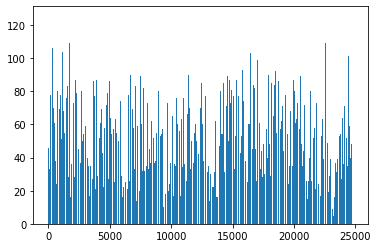

50.66953153371263


In [111]:
#average len of tweet
avg=0
num=[]
x=[x for x in range(24783)]
for n in range(tweet.shape[0]):
    avg+=len(tweet[n])
    num.append(len(tweet[n]))
avg=avg/(tweet.shape[0])
plt.bar(x,num)
plt.show()
print(avg)

In [112]:
word=[]
for i in range(tweet.shape[0]):
    w=tweet[i].replace('\n','').rstrip()
    w1=w.split(" ")
    word.append(w1)
def flatten(seq):
    s=str(seq).replace('[', '').replace(']', '') 
    return [eval(x) for x in s.split(',') if x.strip()] 
word=[x for x in flatten(word)]
word=[x for x in word if x!='']
len(word)

212672

Create the input data for word2vec

In [113]:
for i in range(len(tweet)):
    doc=tweet[i]
    doc=doc.split(" ")
    doc=[x for x in doc if x!='']
    tweet[i]=doc
tweet[:5]

0    [mayasolovely, woman, shouldn, complain, clean...
1    [mleew, boy, das, coldyga, dwn, bad, cuffin, d...
2    [ukindofband, dawg, sbabylife, eve, fuck, bich...
3             [cgandeson, vivabased, look, like, anny]
4    [shenikaobes, shi, hea, migh, ue, migh, fake, ...
Name: tweet, dtype: object

word2vec by skip-gram

In [114]:
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
model = Word2Vec(size=100, workers=5,sg=1)  #dimension is 200, consider 5 words, using skip-gram
model.build_vocab(tweet)
model.train(tweet,total_examples = model.corpus_count,epochs = 5)


(721048, 1063360)

In [124]:
warnings.filterwarnings("ignore")
word_vec=[]
#average each word vector to get the vector of a single tweet
for i in range(len(tweet)):
    sum1=0
    for w in tweet[i]:
        try:
            sum1+=model[w]
        except:
            continue
    avg=sum1/(len(tweet[i]))
    avg=list(avg)
    word_vec.append(avg)
word_vec[:5]     

TypeError: 'float' object is not iterable

In [119]:
len(word_vec)

24783

In [106]:
word_vec_array=np.array(word_vec)
word_vec_l=np.reshape(word_vec_array[0],(1,100))
for i in range(len(tweet)):
    array=np.reshape(word_vec_array[i],(1,100))
    word_vec_l=np.r_[word_vec_l,array]
word_vec_l

IndexError: index 598 is out of bounds for axis 0 with size 598

In [55]:
word_vec_lt=word_vec_l
word_vec_lt=np.delete(word_vec_lt,0,0)
word_vec_lt.shape

(598, 100)

In [120]:
#save this array as csv

f = open('../data/word2vec_skip.csv', 'w')
a = csv.writer(f)
a.writerows(word_vec_lt)
f.close()

In [122]:
np.savetxt('../data/word2vec_skip1.csv', word_vec_lt, delimiter = ',')  

## 3.LDA

construct dic for LDA 

In [92]:
dictionary = corpora.Dictionary(tweet)
corpus = [dictionary.doc2bow(words) for words in tweet]

Find the optimal topic numbers

In [101]:
for i in [50, 60, 70, 80]:
    lda = models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=i)
    coherence_model_lda = CoherenceModel(model=lda, texts=tweet, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('\nCoherence Score: ', coherence_lda)
    


Coherence Score:  0.38819085916417634

Coherence Score:  0.42194391540606735

Coherence Score:  0.43920979717599234

Coherence Score:  0.41266646537218143


In [102]:
# lda model, num_topics is the number of topic
lda = models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=70)
# print 5 words for each topic 
for topic in lda.print_topics(num_words=5):
    print(topic)
# topic infer
lda_infer= lda.inference(corpus)
print(lda.inference(corpus))

(64, '0.200*"man" + 0.074*"show" + 0.043*"eveyhing" + 0.039*"bich" + 0.028*"one"')
(68, '0.147*"n" + 0.121*"us" + 0.066*"wo" + 0.047*"done" + 0.043*"bae"')
(55, '0.165*"alk" + 0.130*"bou" + 0.033*"kid" + 0.029*"youve" + 0.027*"bich"')
(30, '0.122*"bee" + 0.108*"yellow" + 0.067*"bich" + 0.056*"ied" + 0.043*"ask"')
(23, '0.134*"fa" + 0.128*"new" + 0.077*"bich" + 0.063*"die" + 0.046*"ype"')
(13, '0.108*"geing" + 0.088*"black" + 0.072*"nohing" + 0.057*"h" + 0.051*"kids"')
(67, '0.141*"gil" + 0.103*"call" + 0.087*"wie" + 0.044*"like" + 0.042*"days"')
(10, '0.087*"sa" + 0.063*"song" + 0.061*"had" + 0.047*"sick" + 0.047*"pussies"')
(37, '0.118*"gonna" + 0.056*"fee" + 0.043*"im" + 0.043*"use" + 0.037*"somebody"')
(3, '0.113*"lile" + 0.110*"bich" + 0.096*"always" + 0.043*"wish" + 0.043*"hai"')
(39, '0.077*"hi" + 0.068*"niggah" + 0.064*"gon" + 0.064*"onigh" + 0.062*"back"')
(11, '0.107*"alking" + 0.079*"well" + 0.074*"side" + 0.041*"ges" + 0.037*"calling"')
(8, '0.146*"look" + 0.116*"like" + 0.0

In [103]:
print(lda_infer[0].shape)

(24783, 70)


In [104]:
lda_infer = pd.DataFrame(lda_infer[0])
lda_infer.to_csv("../data/lda_infer.csv", index = False)

In [24]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import svm
import string
import re
import nltk

# Evaluation Matrix

In [36]:
from sklearn.metrics import f1_score, precision_recall_fscore_support, classification_report

def evaluation(real_labels, pred_labels):
    f1_micro = f1_score(real_labels, pred_labels, average='micro')
    f1_macro = f1_score(real_labels, pred_labels, average='macro')
    f1_weighted = f1_score(real_labels, pred_labels, average='weighted')
    #f1_binary = f1_score(real_labels, pred_labels, average='binary')
    #f1_samples = f1_score(real_labels, pred_labels, average='samples')

    micro_p, micro_r, micro_f1, _ = precision_recall_fscore_support(real_labels, pred_labels, average='micro')
    macro_p, macro_r, macro_f1, _ = precision_recall_fscore_support(real_labels, pred_labels, average='macro')
    

    report = classification_report(real_labels, pred_labels)

    print('f1 micro: ',f1_micro)
    print('f1 macro: ',f1_macro)
    print('f1 weighted: ',f1_weighted)
    #print('f1 binary: ',f1_binary)
    #print('f1 samples: ',f1_samples)
    print('micro p, micro r, micro f1:', micro_p, micro_r, micro_f1)
    print('macro p, macro r, macro f1:', macro_p, macro_r, macro_f1)
    print(report)


# Load Data

In [78]:
X_ski = pd.read_csv('../data/word2vec_skip2.csv',header=None)
X_lda = pd.read_csv('../data/lda_infer.csv')
X_liwc = pd.read_csv('../data/LIWC.csv')
y = pd.read_csv('../data/labeled_data.csv')['class']
X_ski.shape,X_lda.shape, X_liwc.shape

((24783, 100), (24783, 70), (24783, 17))

# Standardize Data

In [26]:
scaler = StandardScaler()
scaler.fit(X_ski)
X_ski = pd.DataFrame(scaler.transform(X_ski))
scaler.fit(X_lda)
X_lda = pd.DataFrame(scaler.transform(X_lda))
scaler.fit(X_liwc)
X_liwc = pd.DataFrame(scaler.transform(X_liwc))

In [76]:
X_lda.columns = list(range(101,171))
X_all = pd.concat([X_ski, X_lda, X_liwc], axis=1)
X_all

,0,1,2,3,4,5,6,7,8,9,...,7,8,9,10,11,12,13,14,15,16
0,-0.210364,-0.432598,-0.997330,0.870346,-1.034201,0.125785,-0.308096,0.768088,-0.112404,-0.485286,...,0.556133,1.250531,-0.424595,0.934323,-0.660135,-0.555307,-0.439245,-0.460441,0.893203,-0.49192
1,-0.970142,0.184729,0.762217,0.069552,0.504674,0.281666,-1.103539,-0.847527,0.553633,1.255813,...,0.556133,1.250531,-0.424595,-0.562272,-0.660135,-0.555307,1.577765,-0.460441,0.893203,-0.49192
2,-0.507980,-0.775718,0.262399,0.749621,-0.418676,-0.965173,0.799103,0.480935,-0.230887,-0.661697,...,1.818742,3.010036,1.665324,0.934323,0.622409,0.987364,-0.439245,-0.460441,0.893203,-0.49192
3,-0.718547,0.118731,-1.381494,-0.043071,0.471597,1.835291,-1.708760,0.099431,-1.110124,-0.801691,...,-0.706476,-0.508973,-0.424595,-0.562272,-0.660135,-0.555307,1.577765,-0.460441,-0.577253,-0.49192
4,-0.889593,-1.040487,1.200376,0.996471,-0.239872,-1.111058,0.795121,0.486174,0.017350,-0.311059,...,0.556133,1.250531,-0.424595,-0.562272,-0.660135,-0.555307,-0.439245,-0.460441,0.893203,-0.49192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24778,0.439394,1.183971,-0.918551,-0.949504,0.048243,1.495339,-1.156798,-0.855282,0.710415,1.252661,...,-0.706476,-0.508973,-0.424595,-0.562272,-0.660135,-0.555307,-0.439245,-0.460441,-0.577253,-0.49192
24779,-0.237918,-1.377332,0.347184,1.690207,-1.265389,-0.788985,0.281229,1.067327,0.934023,0.176924,...,-0.706476,-0.508973,-0.424595,-0.562272,-0.660135,-0.555307,-0.439245,-0.460441,0.893203,-0.49192
24780,-0.727257,-1.709331,1.590391,1.838453,1.139058,-1.406139,-0.940876,0.227202,-1.304643,0.536335,...,0.556133,1.250531,1.665324,0.934323,0.622409,0.987364,-0.439245,-0.460441,0.893203,-0.49192
24781,1.241618,0.058139,0.255205,-0.361494,0.767290,-0.042059,0.154172,0.396215,-1.199854,0.053228,...,0.556133,1.250531,1.665324,-0.562272,-0.660135,-0.555307,-0.439245,-0.460441,0.893203,-0.49192


## Split Data 

In [87]:
X_all_train, X_all_test, y_train, y_test = train_test_split(X_all, y, random_state=17, test_size=0.1)
X_ski_train, X_ski_test = X_all_train.iloc[:, list(range(0,100))], X_all_test.iloc[:, list(range(0,100))]
X_lda_train, X_lda_test = X_all_train.iloc[:, list(range(100,170))], X_all_test.iloc[:, list(range(100,170))]
X_liwc_train, X_liwc_test = X_all_train.iloc[:, list(range(170,187))], X_all_test.iloc[:, list(range(170,187))]
X_liwc_lda_train, X_liwc_lda_test = pd.concat([X_lda_train, X_liwc_train], axis=1), pd.concat([X_lda_test, X_liwc_test], axis=1)
X_ski_lda_train, X_ski_lda_test = pd.concat([X_lda_train, X_ski_train], axis=1), pd.concat([X_lda_test, X_ski_test], axis=1)
X_liwc_ski_train, X_liwc_ski_test = pd.concat([X_ski_train, X_liwc_train], axis=1), pd.concat([X_ski_test, X_liwc_test], axis=1)

# Feature Combination

In [89]:
model = LogisticRegression(max_iter = 2000).fit(X_all_train, y_train)
y_preds = model.predict(X_all_test)
evaluation(y_preds, y_test)

f1 micro:  0.8846308995562727
f1 macro:  0.6409930966529657
f1 weighted:  0.8991726366801739
micro p, micro r, micro f1: 0.8846308995562727 0.8846308995562727 0.8846308995562727
macro p, macro r, macro f1: 0.6353561160087069 0.7208947581600446 0.6409930966529657
              precision    recall  f1-score   support

           0       0.12      0.49      0.19        35
           1       0.95      0.92      0.93      2010
           2       0.84      0.76      0.79       434

    accuracy                           0.88      2479
   macro avg       0.64      0.72      0.64      2479
weighted avg       0.92      0.88      0.90      2479



In [90]:
model = LogisticRegression(max_iter = 2000).fit(X_ski_train, y_train)
y_preds = model.predict(X_ski_test)
evaluation(y_preds, y_test)

f1 micro:  0.8830173457039129
f1 macro:  0.6390490485413304
f1 weighted:  0.8980547360428501
micro p, micro r, micro f1: 0.8830173457039129 0.8830173457039129 0.8830173457039129
macro p, macro r, macro f1: 0.6312973771712175 0.7387798107721718 0.6390490485413304
              precision    recall  f1-score   support

           0       0.12      0.55      0.20        31
           1       0.95      0.92      0.93      2017
           2       0.82      0.75      0.79       431

    accuracy                           0.88      2479
   macro avg       0.63      0.74      0.64      2479
weighted avg       0.92      0.88      0.90      2479



In [92]:
model = LogisticRegression(max_iter = 2000).fit(X_lda_train, y_train)
y_preds = model.predict(X_lda_test)
evaluation(y_preds, y_test)

f1 micro:  0.7918515530455829
f1 macro:  0.37432030499552615
f1 weighted:  0.8528944220732593
micro p, micro r, micro f1: 0.7918515530455829 0.7918515530455829 0.7918515530455829
macro p, macro r, macro f1: 0.3775714552912366 0.44655208240567584 0.37432030499552615
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.98      0.80      0.88      2364
           2       0.15      0.54      0.24       114

    accuracy                           0.79      2479
   macro avg       0.38      0.45      0.37      2479
weighted avg       0.94      0.79      0.85      2479



In [93]:
model = LogisticRegression(max_iter = 2000).fit(X_liwc_train, y_train)
y_preds = model.predict(X_liwc_test)
evaluation(y_preds, y_test)

f1 micro:  0.7841871722468737
f1 macro:  0.29301379154420076
f1 weighted:  0.8786867794834967
micro p, micro r, micro f1: 0.7841871722468737 0.7841871722468737 0.7841871722468737
macro p, macro r, macro f1: 0.3331619537275064 0.26150121065375304 0.29301379154420076
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.78      0.88      2478
           2       0.00      0.00      0.00         1

    accuracy                           0.78      2479
   macro avg       0.33      0.26      0.29      2479
weighted avg       1.00      0.78      0.88      2479



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [94]:
model = LogisticRegression(max_iter = 2000).fit(X_liwc_lda_train, y_train)
y_preds = model.predict(X_liwc_lda_test)
evaluation(y_preds, y_test)

f1 micro:  0.7958854376764825
f1 macro:  0.40876158511903316
f1 weighted:  0.8436507391061131
micro p, micro r, micro f1: 0.7958854376764825 0.7958854376764825 0.7958854376764825
macro p, macro r, macro f1: 0.40424708241445156 0.45470788806052465 0.40876158511903316
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.96      0.82      0.88      2296
           2       0.25      0.55      0.34       179

    accuracy                           0.80      2479
   macro avg       0.40      0.45      0.41      2479
weighted avg       0.91      0.80      0.84      2479



In [95]:
model = LogisticRegression(max_iter = 2000).fit(X_ski_lda_train, y_train)
y_preds = model.predict(X_ski_lda_test)
evaluation(y_preds, y_test)

f1 micro:  0.8838241226300928
f1 macro:  0.6360190315776292
f1 weighted:  0.8989315314304018
micro p, micro r, micro f1: 0.8838241226300928 0.8838241226300928 0.8838241226300928
macro p, macro r, macro f1: 0.6294305636077457 0.7159807019725203 0.6360190315776292
              precision    recall  f1-score   support

           0       0.11      0.47      0.18        34
           1       0.95      0.92      0.93      2019
           2       0.82      0.76      0.79       426

    accuracy                           0.88      2479
   macro avg       0.63      0.72      0.64      2479
weighted avg       0.92      0.88      0.90      2479



In [96]:
model = LogisticRegression(max_iter = 2000).fit(X_liwc_ski_train, y_train)
y_preds = model.predict(X_liwc_ski_test)
evaluation(y_preds, y_test)

f1 micro:  0.8850342880193626
f1 macro:  0.6454233200252131
f1 weighted:  0.8993412883818996
micro p, micro r, micro f1: 0.8850342880193627 0.8850342880193627 0.8850342880193626
macro p, macro r, macro f1: 0.6404356447210048 0.7433920838534395 0.6454233200252131
              precision    recall  f1-score   support

           0       0.13      0.56      0.21        32
           1       0.95      0.92      0.93      2001
           2       0.85      0.75      0.79       446

    accuracy                           0.89      2479
   macro avg       0.64      0.74      0.65      2479
weighted avg       0.92      0.89      0.90      2479



Seems LIWC & Skip-Learn seems to be the best combination. 
Since the Coherence Score on LDA is lower than 0.5, 
it could be a good idea to remove lda features.

# Feature Selection

In [112]:
select = SelectFromModel(LogisticRegression(class_weight='balanced',
                                            penalty="l1",C=0.01, solver = 'saga', 
                                            max_iter = 2000)).fit(X_liwc_ski_train,y_train)
#X_liwc_ski_train_ = select.fit_transform(X_liwc_ski_train,y_train)


feature_idx = select.get_support()
selected_columns = X_liwc_ski_train.columns[feature_idx]
X_liwc_ski_train_ = X_liwc_ski_train[selected_columns]
X_liwc_ski_test_ = X_liwc_ski_test[selected_columns]
X_liwc_ski_train_.shape

(22304, 61)

In [101]:
corr = X_liwc_ski_train.corr()

columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.3:
            if columns[j]:
                columns[j] = False
selected_columns = X_liwc_ski_train.columns[columns]
X_liwc_ski_train_f = X_liwc_ski_train[selected_columns]
X_liwc_ski_test_f = X_liwc_ski_test[selected_columns]
X_train_f.shape

(22304, 84)

In [115]:
model = LogisticRegression(max_iter = 2000).fit(X_liwc_ski_train_, y_train)
y_preds = model.predict(X_liwc_ski_test_)
evaluation(y_preds, y_test)

f1 micro:  0.8781766841468334
f1 macro:  0.6231050690803706
f1 weighted:  0.8938602955502181
micro p, micro r, micro f1: 0.8781766841468334 0.8781766841468334 0.8781766841468334
macro p, macro r, macro f1: 0.6226121035759181 0.7201859052757533 0.6231050690803706
              precision    recall  f1-score   support

           0       0.10      0.52      0.17        27
           1       0.95      0.92      0.93      2005
           2       0.82      0.72      0.77       447

    accuracy                           0.88      2479
   macro avg       0.62      0.72      0.62      2479
weighted avg       0.91      0.88      0.89      2479



Full Model has better performance

# Model Selection

In [116]:
model = svm.LinearSVC(max_iter = 2000).fit(X_liwc_ski_train, y_train)
y_preds = model.predict(X_liwc_ski_test)
evaluation(y_preds, y_test)

f1 micro:  0.8842275110931828
f1 macro:  0.6105923159112313
f1 weighted:  0.9035868503861484
micro p, micro r, micro f1: 0.8842275110931828 0.8842275110931828 0.8842275110931828
macro p, macro r, macro f1: 0.6173225136752598 0.7136861722478759 0.6105923159112313
              precision    recall  f1-score   support

           0       0.06      0.47      0.10        17
           1       0.95      0.92      0.93      2022
           2       0.84      0.75      0.80       440

    accuracy                           0.88      2479
   macro avg       0.62      0.71      0.61      2479
weighted avg       0.93      0.88      0.90      2479



/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Logistic Regression has better performance, and SVM doesn't converge.

# Hyper-parameter Tuning

In [ ]:
# define models and parameters
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, 
                           cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_liwc_ski_train, y_train)
y_preds = grid_result.predict(X_liwc_ski_test)
evaluation(y_preds, y_test)